# 2. Potential Evapotranspiration from ZAMG INCA data (NetCDF)
*M. Vremec, October 2022, University of Graz*


What is done:

- load the data from ZAMG
- estimate potential evapotranspiration
- plot and store results

Data source: ZAMG - https://data.hub.zamg.ac.at

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyet
pyet.show_versions()

Python version: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
Numpy version: 1.26.2
Pandas version: 2.1.3
Pyet version: 1.2.3b


## Loading daily data from ZAMG (INCA hourly NetCDF data)

In [2]:
#read data
xr_ds = xr.open_dataset("data//example_2//incal_hourly_20120501T0000_20120930T2300.nc", 
            engine="netcdf4")

In [3]:
# Resample and define input meteorological variables
tmean = xr_ds["T2M"].resample(time="1D").mean()
tmax = xr_ds["T2M"].resample(time="1D").max()
tmin = xr_ds["T2M"].resample(time="1D").min()
rh = xr_ds["RH2M"].resample(time="1D").mean()
rhmax = xr_ds["RH2M"].resample(time="1D").max()
rhmin = xr_ds["RH2M"].resample(time="1D").min()
wind = ((np.abs(xr_ds["VV"]) + np.abs(xr_ds["UU"])) / 2).resample(time="1D").mean()
rs = xr_ds["GL"].resample(time="1D").mean() * 86400 / 1000000

In [4]:
# Define latitude and elevation
lat =  tmean.lat * np.pi / 180  
elevation = lat / lat * 350

## Calculate PET

In [5]:
lat1 = 80 * np.pi / 180

In [6]:
tindex = pyet.get_index(tmean)
j = pyet.day_of_year(tindex)
sol_dec = pyet.solar_declination(j)
sangle = pyet.sunset_angle(sol_dec, lat)
    # Account for subpolar belt which returns NaN values
dl = 24 / np.pi * sangle
ra = pyet.extraterrestrial_r(tindex, lat, tmean.shape)

In [7]:
# Estimate evapotranspiration with nine different methods 
pet_penman = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_pt = pyet.priestley_taylor(tmean, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_makkink = pyet.makkink(tmean, rs, elevation=elevation)
pet_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pet_hamon = pyet.hamon(tmean, lat=lat, method=1)
pet_oudin = pyet.oudin(tmean, lat=lat)
pet_haude = pyet.haude(tmax, rh)
pet_turc = pyet.turc(tmean, rs, rh)
pet_har = pyet.hargreaves(tmean, tmax, tmin, lat)

### Plot results

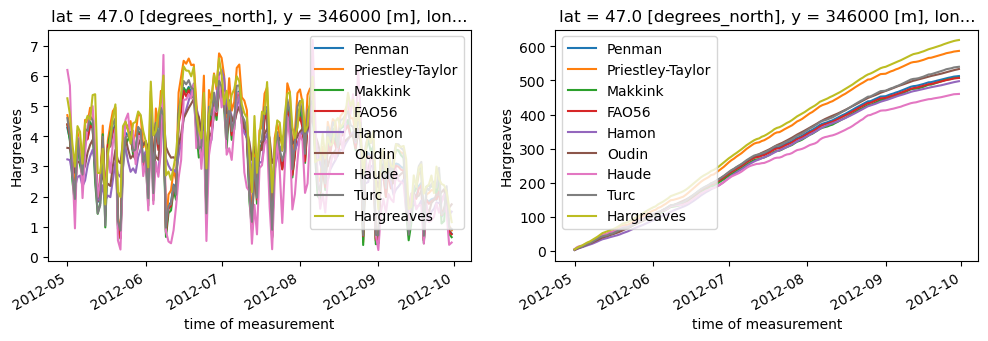

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(12,3))
pet_penman[:,2,2].plot(ax=axs[0], label="Penman")
pet_pt[:,2,2].plot(ax=axs[0], label="Priestley-Taylor")
pet_makkink[:,2,2].plot(ax=axs[0], label="Makkink")
pet_fao56[:,2,2].plot(ax=axs[0], label="FAO56")
pet_hamon[:,2,2].plot(ax=axs[0], label="Hamon")
pet_oudin[:,2,2].plot(ax=axs[0], label="Oudin")
pet_haude[:,2,2].plot(ax=axs[0], label="Haude")
pet_turc[:,2,2].plot(ax=axs[0], label="Turc")
pet_har[:,2,2].plot(ax=axs[0], label="Hargreaves")
axs[0].legend()

pet_penman[:,2,2].cumsum().plot(ax=axs[1], label="Penman")
pet_pt[:,2,2].cumsum().plot(ax=axs[1], label="Priestley-Taylor")
pet_makkink[:,2,2].cumsum().plot(ax=axs[1], label="Makkink")
pet_fao56[:,2,2].cumsum().plot(ax=axs[1], label="FAO56")
pet_hamon[:,2,2].cumsum().plot(ax=axs[1], label="Hamon")
pet_oudin[:,2,2].cumsum().plot(ax=axs[1], label="Oudin")
pet_haude[:,2,2].cumsum().plot(ax=axs[1], label="Haude")
pet_turc[:,2,2].cumsum().plot(ax=axs[1], label="Turc")
pet_har[:,2,2].cumsum().plot(ax=axs[1], label="Hargreaves")
axs[1].legend()

# Compare point with pandas.Series vs. point from xarray.DataArray

In [9]:
tmeans = xr_ds["T2M"].resample(time="1D").mean()[:, 4, 4].to_series()
tmaxs = xr_ds["T2M"].resample(time="1D").max()[:, 4, 4].to_series()
tmins = xr_ds["T2M"].resample(time="1D").min()[:, 4, 4].to_series()
rhs = xr_ds["RH2M"].resample(time="1D").mean()[:, 4, 4].to_series()
rhmaxs = xr_ds["RH2M"].resample(time="1D").max()[:, 4, 4].to_series()
rhmins = xr_ds["RH2M"].resample(time="1D").min()[:, 4, 4].to_series()
winds = ((np.abs(xr_ds["VV"]) + np.abs(xr_ds["UU"])) / 2).resample(time="1D").mean()[:, 4, 4].to_series()
rss = (xr_ds["GL"].resample(time="1D").mean() * 86400 / 1000000)[:, 4, 4].to_series()
lats = float(lat[4, 4])
elevations = float(elevation[4, 4])

In [10]:
# Estimate evapotranspiration with nine different methods with Pandas.Series
pet_penmans = pyet.penman(tmeans, winds, rs=rss, elevation=elevations, lat=lats, tmax=tmaxs, tmin=tmins, rh=rhs)
pet_pts = pyet.priestley_taylor(tmeans, rs=rss, elevation=elevations, lat=lats, tmax=tmaxs, tmin=tmins, rh=rhs)
pet_makkinks = pyet.makkink(tmeans, rss, elevation=elevations)
pet_fao56s = pyet.pm_fao56(tmeans, winds, rs=rss, elevation=elevations, lat=lats, tmax=tmaxs, tmin=tmins, rh=rhs)
pet_hamons = pyet.hamon(tmeans, lat=lats, method=1)
pet_oudins = pyet.oudin(tmeans, lat=lats)
pet_haudes = pyet.haude(tmaxs, rhs)
pet_turcs = pyet.turc(tmeans, rss, rhs)
pet_hars = pyet.hargreaves(tmeans, tmaxs, tmins, lats)

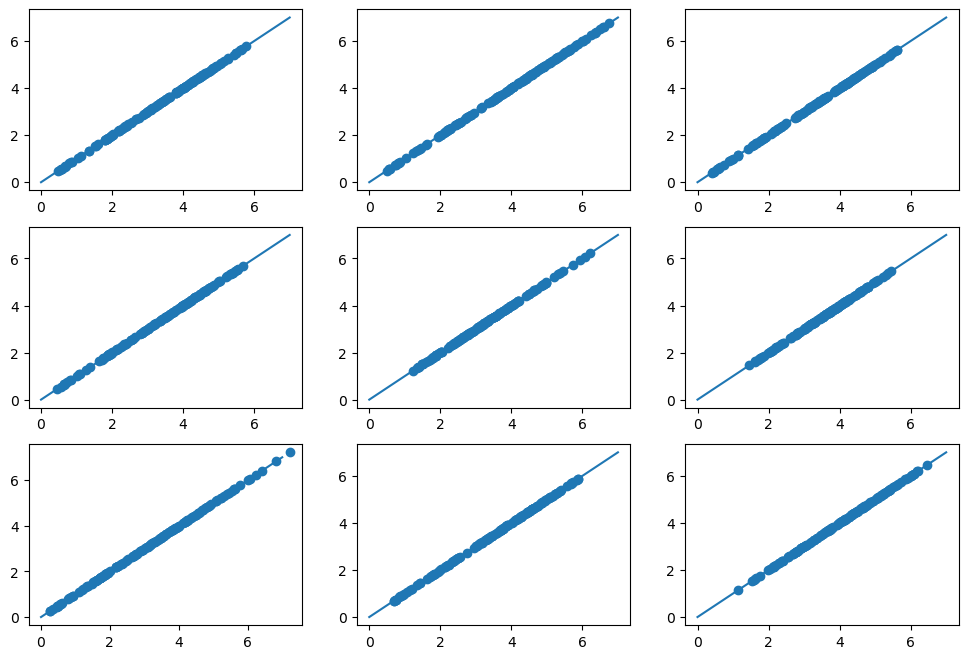

In [11]:
fm = """
    ABC
    DEF
    GHI
    """
fig,axs = plt.subplot_mosaic(mosaic=fm, figsize=(12,8))
axs["A"].scatter(pet_penman[:,4,4].values, pet_penmans.values)
axs["B"].scatter(pet_pt[:,4,4].values, pet_pts.values)
axs["C"].scatter(pet_makkink[:,4,4].values, pet_makkinks.values)
axs["D"].scatter(pet_fao56[:,4,4].values, pet_fao56s.values)
axs["E"].scatter(pet_hamon[:,4,4].values, pet_hamons.values)
axs["F"].scatter(pet_oudin[:,4,4].values, pet_oudins.values)
axs["G"].scatter(pet_haude[:,4,4].values, pet_haudes.values)
axs["H"].scatter(pet_turc[:,4,4].values, pet_turcs.values)
axs["I"].scatter(pet_har[:,4,4].values, pet_hars.values)
for i in axs.keys():
    axs[i].plot([0,7], [0,7])

### Store results

In [12]:
#pet_pt.to_netcdf('../pe_pt_INCA.csv')